### 데이터사이언스융합학과 2024710658 박창준

# Google Colab amount

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### 패키치 설치 및 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

C:\Dev\miniconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Load

In [3]:
df = pd.read_csv("D:/박창준 문서/4. 대학교육/2. 성균관대학교 일반대학원/Code/24.1 기계학습특론/13주차 과제-2 데이터.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78204 entries, 0 to 78203
Columns: 539 entries, site to MAX19
dtypes: int64(536), object(3)
memory usage: 321.6+ MB


- 데이터 분할

In [5]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['leaktype'])  # 종속 변수를 제외한 모든 독립 변수들
y = df['leaktype']  # 종속 변수

# train과 test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle = True)

In [6]:
train = pd.concat([X_train, y_train], axis=1)
# 인덱스를 다시 설정
train.reset_index(drop=True, inplace=True)

In [7]:
test = pd.concat([X_test, y_test], axis=1)
# 인덱스를 다시 설정
test.reset_index(drop=True, inplace=True)

### EDA & Preprocessing

- 데이터 개형 확인

In [8]:
df.shape

(78204, 539)

In [9]:
train.shape

(62563, 539)

In [10]:
test.shape

(15641, 539)

- 타겟컬럼 분포 확인

In [11]:
train['leaktype'].value_counts()

leaktype
normal    19702
out       17538
in        13273
other      7020
noise      5030
Name: count, dtype: int64

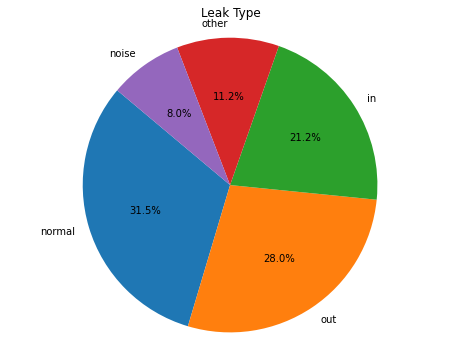

In [12]:
import matplotlib.pyplot as plt

# credit 컬럼의 값 빈도 계산
leaktype_counts = train['leaktype'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
plt.pie(leaktype_counts, labels=leaktype_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Leak Type')
plt.axis('equal')
plt.show()

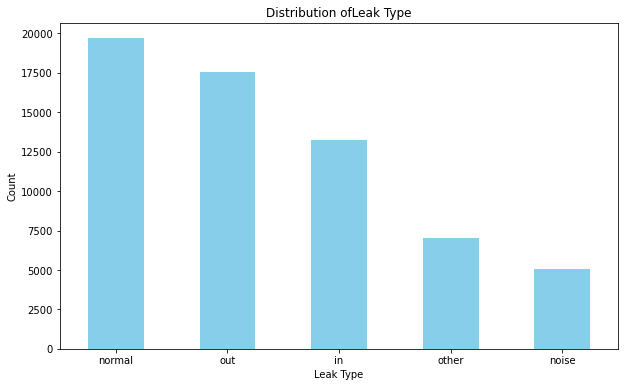

In [13]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
leaktype_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution ofLeak Type')
plt.xlabel('Leak Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

- Numeric column, Categorical column 나누기

In [14]:
# dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)

In [15]:
len(numerical_list)

536

In [16]:
len(categorical_list)

3

- 결측치 확인 및 처리

In [17]:
train.isnull().sum().sum()

0

In [18]:
test.isnull().sum().sum()

0

- 중복 확인 및 처리(행간 중복 없음)

In [19]:
train.duplicated(keep = False).sum()

0

In [20]:
test.duplicated(keep = False).sum()

0

In [21]:
df[categorical_list].drop('leaktype', axis = 1).duplicated(keep = False).sum()

77886

- Numerical Data 이상치 분석(IQR 사용)

In [22]:
def num_outliers_iqr(df, columns):
    # 이상치가 있는 컬럼을 저장할 리스트
    columns_with_outliers = []
    
    # IQR을 이용해 이상치가 있는지 확인
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[((df[col] < lower_bound) | (df[col] > upper_bound))]
        if not outliers.empty:
            columns_with_outliers.append(col)
        
    return columns_with_outliers

In [23]:
len(num_outliers_iqr(train, numerical_list))

534

In [24]:
def visualize_outliers_iqr(df, columns):
    # 이상치가 있는 컬럼을 저장할 리스트
    columns_with_outliers = []
    
    # IQR을 이용해 이상치가 있는지 확인
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[((df[col] < lower_bound) | (df[col] > upper_bound))]
        if not outliers.empty:
            columns_with_outliers.append(col)
    
    # 이상치가 있는 컬럼 시각화
    num_cols = len(columns_with_outliers)
    fig, axes = plt.subplots((num_cols + 1) // 2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(columns_with_outliers):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)
    
    # 빈 서브플롯 숨기기
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    return columns_with_outliers

['10HZ', '20HZ', '30HZ', '40HZ', '50HZ', '60HZ']

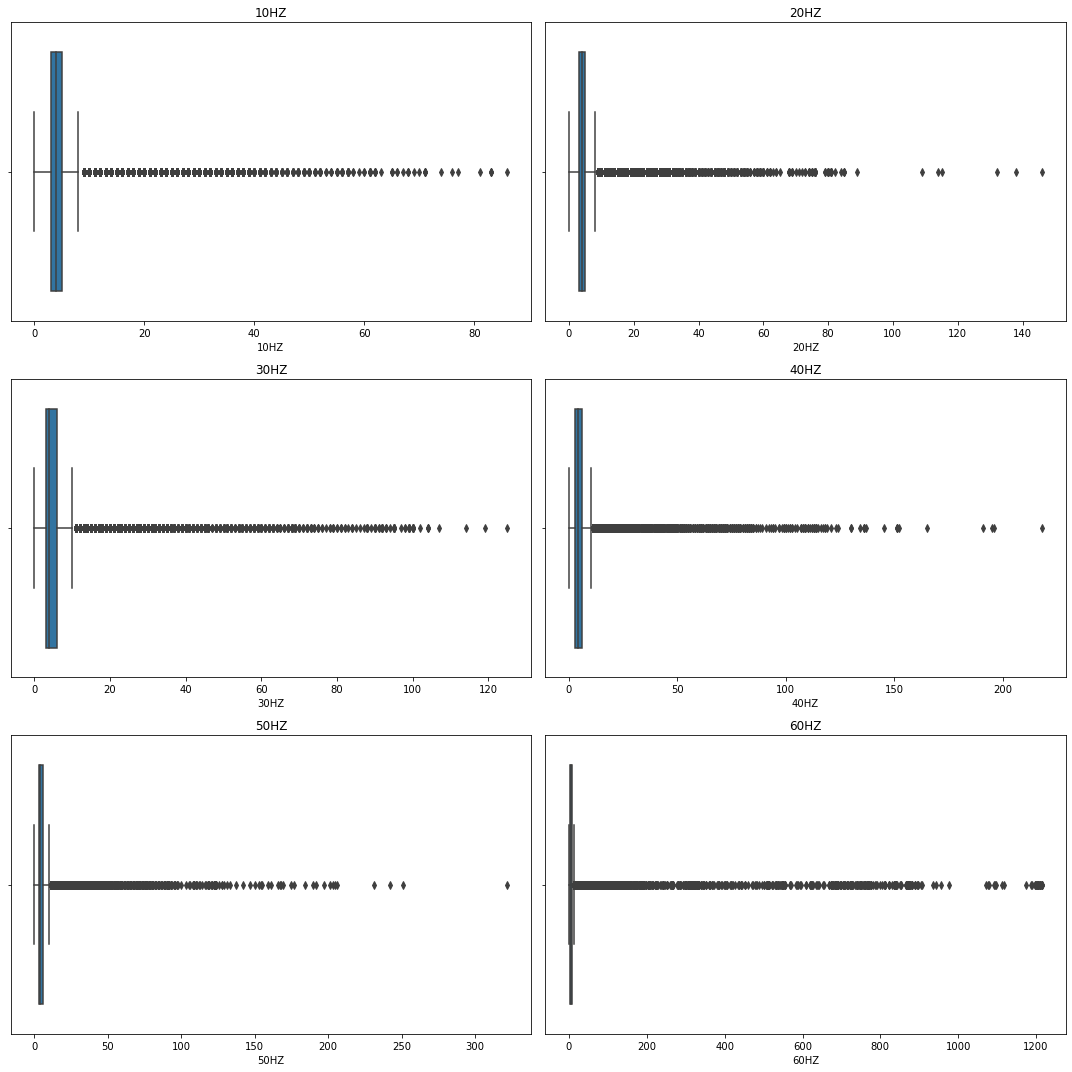

In [25]:
visualize_outliers_iqr(train, numerical_list[3:10])

- Numerical Data 이상치 분석(std 사용)

In [26]:
def num_outliers_std(df, columns):
    # 이상치가 있는 컬럼을 저장할 리스트
    columns_with_outliers = []
    
    # 평균과 표준편차를 이용해 이상치가 있는지 확인
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        outliers = df[((df[col] < lower_bound) | (df[col] > upper_bound))]
        if not outliers.empty:
            columns_with_outliers.append(col)
    return columns_with_outliers

In [27]:
len(num_outliers_std(train, numerical_list))

533

In [28]:
def visualize_outliers_std(df, columns):
    # 이상치가 있는 컬럼을 저장할 리스트
    columns_with_outliers = []
    
    # 평균과 표준편차를 이용해 이상치가 있는지 확인
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        outliers = df[((df[col] < lower_bound) | (df[col] > upper_bound))]
        if not outliers.empty:
            columns_with_outliers.append(col)
    
    # 이상치가 있는 컬럼 시각화
    num_cols = len(columns_with_outliers)
    fig, axes = plt.subplots((num_cols + 1) // 2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(columns_with_outliers):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)
    
    # 빈 서브플롯 숨기기
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return columns_with_outliers

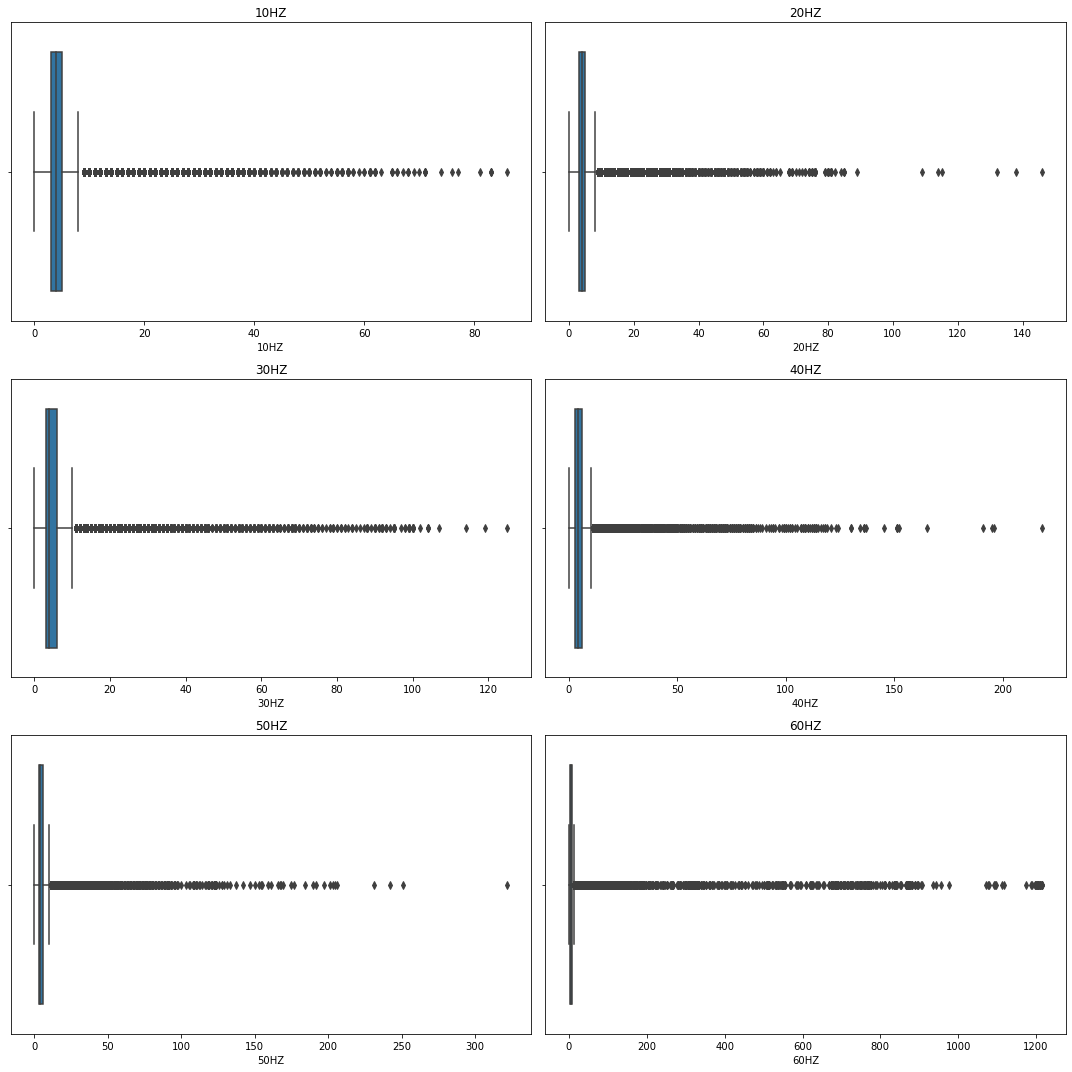

['10HZ', '20HZ', '30HZ', '40HZ', '50HZ', '60HZ']

In [29]:
# 이상치 분석 및 시각화
visualize_outliers_std(train, numerical_list[3:10])

- 대다수의 컬럼에 이상치가 상당수 존재함을 확인함.

- 컬럼별 분포 시각화

In [30]:
def visualize_histograms(df, columns):
    num_cols = len(columns)
    num_rows = (num_cols + 1) // 2  # 2개씩 한 행에 표시할 때 필요한 행 수
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
    
    for i, col in enumerate(columns):
        row = i // 2
        col_idx = i % 2
        sns.histplot(df[col], bins=30, kde=True, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'Histogram of {col}')
    
    # 빈 서브플롯 숨기기
    if num_cols % 2 != 0:  # 컬럼 수가 홀수인 경우 마지막 빈 플롯 숨기기
        fig.delaxes(axes[-1, -1])
    
    plt.tight_layout()
    plt.show()

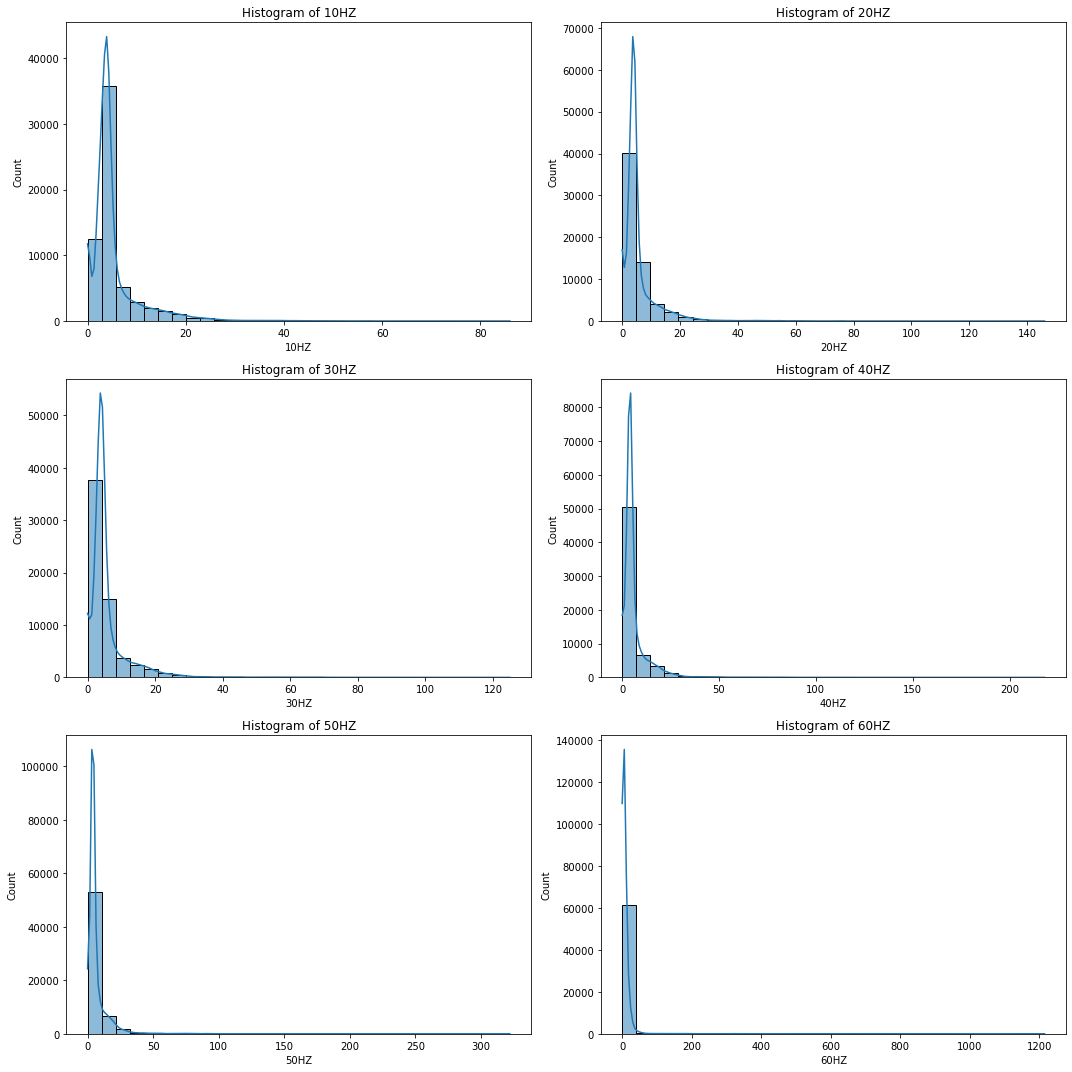

In [31]:
visualize_histograms(train, numerical_list[4:10])

- 컬럼별 통계값 확인

In [32]:
df.describe()

,ldate,lrate,llevel,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
count,7.820400e+04,78204.000000,78204.000000,78204.0,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,...,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000,78204.000000
mean,2.020077e+07,75.927830,447.389085,0.0,5.286750,5.563462,5.921705,6.318066,6.736535,11.075393,...,508.333973,413.887768,503.701345,413.563986,504.530970,413.198430,510.308680,414.102399,508.962457,411.420963
std,5.821291e+03,22.215952,240.614511,0.0,5.669245,6.292279,7.163296,8.228361,9.395276,53.026551,...,815.742107,286.624201,804.222266,286.693057,805.465604,286.908852,817.779454,287.718706,814.266024,287.577939
min,2.019023e+07,30.000000,106.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.000000,9.000000,30.000000,9.000000,30.000000,9.000000,30.000000,9.000000,30.000000,9.000000
25%,2.020042e+07,60.000000,239.000000,0.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,260.000000,167.000000,260.000000,168.000000,260.000000,167.000000,260.000000,166.000000,260.000000,166.000000
50%,2.020080e+07,90.000000,400.000000,0.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,310.000000,367.000000,310.000000,367.000000,310.000000,366.000000,310.000000,368.000000,310.000000,364.000000
75%,2.020120e+07,90.000000,616.000000,0.0,5.000000,5.000000,6.000000,6.000000,6.000000,7.000000,...,380.000000,613.000000,380.000000,613.000000,380.000000,615.000000,390.000000,617.000000,390.000000,613.000000
max,2.021021e+07,90.000000,1677.000000,0.0,86.000000,146.000000,125.000000,218.000000,322.000000,1221.000000,...,4990.000000,1660.000000,5000.000000,1723.000000,5000.000000,1698.000000,5000.000000,1729.000000,5000.000000,1710.000000


In [33]:
train.describe()

,ldate,lrate,llevel,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
count,6.256300e+04,62563.000000,62563.000000,62563.0,62563.000000,62563.000000,62563.000000,62563.000000,62563.00000,62563.000000,...,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000,62563.000000
mean,2.020077e+07,75.930182,447.694132,0.0,5.296581,5.568515,5.928984,6.329572,6.74397,11.056503,...,508.316097,414.227722,504.714128,413.758819,504.092675,413.742548,510.656618,414.646772,508.662788,411.415437
std,5.831822e+03,22.209389,240.844676,0.0,5.697499,6.315186,7.181781,8.313577,9.46493,52.928817,...,815.718505,286.760750,806.172572,286.845204,804.448983,287.147277,818.208468,288.012945,813.652807,287.189046
min,2.019023e+07,30.000000,106.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,30.000000,9.000000,30.000000,9.000000,30.000000,10.000000,30.000000,9.000000,30.000000,9.000000
25%,2.020042e+07,60.000000,239.000000,0.0,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,...,260.000000,168.000000,260.000000,167.000000,260.000000,167.000000,260.000000,166.000000,260.000000,166.000000
50%,2.020080e+07,90.000000,400.000000,0.0,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,...,310.000000,367.000000,310.000000,367.000000,310.000000,367.000000,310.000000,368.000000,310.000000,364.000000
75%,2.020121e+07,90.000000,617.000000,0.0,5.000000,5.000000,6.000000,6.000000,6.00000,7.000000,...,380.000000,614.000000,380.000000,614.000000,390.000000,616.000000,390.000000,618.000000,390.000000,613.000000
max,2.021021e+07,90.000000,1653.000000,0.0,86.000000,146.000000,125.000000,218.000000,322.00000,1215.000000,...,4990.000000,1660.000000,5000.000000,1723.000000,5000.000000,1698.000000,5000.000000,1706.000000,5000.000000,1705.000000


In [34]:
test.describe()

,ldate,lrate,llevel,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
count,1.564100e+04,15641.000000,15641.000000,15641.0,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,...,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000
mean,2.020077e+07,75.918420,446.168915,0.0,5.247427,5.543252,5.892590,6.272041,6.706796,11.150949,...,508.405473,412.527971,499.650278,412.784668,506.284125,411.021993,508.916949,411.924941,510.161115,411.443066
std,5.779158e+03,22.242893,239.695453,0.0,5.554798,6.199966,7.089028,7.878381,9.111575,53.417330,...,815.862583,286.082474,796.386114,286.091500,809.542695,285.951981,816.085804,286.537586,816.739220,289.137471
min,2.019023e+07,30.000000,125.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.000000,9.000000,30.000000,10.000000,30.000000,9.000000,30.000000,10.000000,30.000000,10.000000
25%,2.020042e+07,60.000000,240.000000,0.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,260.000000,166.000000,260.000000,169.000000,260.000000,167.000000,260.000000,165.000000,260.000000,165.000000
50%,2.020080e+07,90.000000,399.000000,0.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,310.000000,365.000000,310.000000,367.000000,310.000000,363.000000,310.000000,366.000000,310.000000,362.000000
75%,2.020120e+07,90.000000,614.000000,0.0,5.000000,5.000000,6.000000,6.000000,6.000000,7.000000,...,380.000000,612.000000,380.000000,609.000000,380.000000,609.000000,380.000000,613.000000,380.000000,612.000000
max,2.021021e+07,90.000000,1677.000000,0.0,67.000000,113.000000,118.000000,163.000000,205.000000,1221.000000,...,4990.000000,1625.000000,4980.000000,1682.000000,4990.000000,1694.000000,5000.000000,1729.000000,5000.000000,1710.000000


- 의미 없는 컬럼 제거(0HZ)

In [35]:
train.drop(['0HZ'], inplace = True, axis = 1)

In [36]:
test.drop(['0HZ'], inplace = True, axis = 1)

In [37]:
train.shape

(62563, 538)

In [38]:
test.shape

(15641, 538)

- 파생변수 생성

In [39]:
train['ldate'].dtype

dtype('int64')

In [40]:
train['ldate'] = pd.to_datetime(train['ldate'])
test['ldate'] = pd.to_datetime(test['ldate'])

In [41]:
# 연도, 월, 일로 분할
train['year'] = train['ldate'].dt.year
train['month'] = train['ldate'].dt.month
train['day'] = train['ldate'].dt.day
test['year'] = test['ldate'].dt.year
test['month'] = test['ldate'].dt.month
test['day'] = test['ldate'].dt.day

In [42]:
train['ldate'] = train['ldate'].astype('int64')
test['ldate'] = test['ldate'].astype('int64')

In [43]:
# 새로운 컬럼 만들기
train['SiteCode'] = train['site'].astype(str) + train['sid'].astype(str)
test['SiteCode'] = test['site'].astype(str) + test['sid'].astype(str)

- Label Encoding

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoders = {}
train['leaktype'] = le.fit_transform(train['leaktype'])
label_encoders['leaktype'] = le
test['leaktype'] = le.transform(test['leaktype'])

In [45]:
train['leaktype'].head()

0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32

- K-means 활용 파생변수 생성

In [46]:
# 1. dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)
        
numerical_list.remove('ldate')
numerical_list.remove('lrate')
categorical_list += ['ldate', 'lrate']

In [47]:
from sklearn.cluster import KMeans

# Train 데이터에 대한 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
train_clusters = kmeans.fit_predict(train[numerical_list])

# Train 데이터에 클러스터링 결과를 컬럼으로 추가
train['cluster'] = train_clusters

# Test 데이터에 대한 클러스터링 결과 예측
test_clusters = kmeans.predict(test[numerical_list])

# Test 데이터에 클러스터링 결과를 컬럼으로 추가
test['cluster'] = test_clusters

In [48]:
numerical_list += ['cluster']

- Information Value 적용

In [49]:
from optbinning import OptimalBinning

iv_df = []

for i in numerical_list : 
    variable = i
    x = train[variable].values
    y = train['leaktype']
    
    # 데이터가 제대로 전달되었는지 확인
    print(f"Processing variable: {variable}")
    print(f"x shape: {x.shape}, y shape: {y.shape}")
    print(f"x first 5 values: {x[:5]}")
    print(f"y first 5 values: {y[:5]}")
    
    optb = OptimalBinning(name = variable, dtype = "numerical", solver = "cp", max_n_prebins = 3)
    optb.fit(x, y)
    
    binning_table = optb.binning_table
    v1 = binning_table.build()
    
    loop_df = pd.DataFrame({'val' : variable, 'IV' : [v1.loc['Totals', 'IV']]})
    iv_df.append(loop_df)
    
iv_df = pd.concat(iv_df).reset_index(drop = True)

(CVXPY) Jun 12 12:48:17 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 12 12:48:17 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
Processing variable: llevel
x shape: (62563,), y shape: (62563,)
x first 5 values: [168 874 521 993 164]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 10HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [5 0 2 0 4]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 20HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [5 3 4 0 4]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leak

Processing variable: 450HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [19  3  4  0  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 460HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [14  3  4  0  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 470HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [15  3  6  0  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 480HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [10  3  4  0  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 490HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 6 0 4]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 500HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 4 4]
y firs

Processing variable: 930HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 940HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 950HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 960HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 970HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 0 4]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 980HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 6]
y first 5 values: 0    4
1

Processing variable: 1390HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 6 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1400HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1410HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [5 3 6 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1420HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1430HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 6 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1440HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 4 0 5]
y first 5 values: 0 

Processing variable: 1850HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 8 10  4  8  6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1860HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 7 10  4  4  6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1870HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 4 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1880HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 4 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1890HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 4 0 4]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 1900HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 4 5]
y first 5 

Processing variable: 2310HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 8 19  6  8  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2320HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 8 13  4  4  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2330HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 8 10  6  4  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2340HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 9 10  4  4  6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2350HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [9 6 6 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2360HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 6 4 4 5]


Processing variable: 2790HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [20 10  4  4  6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2800HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [20 13  4  4  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2810HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [21 13  6  4  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2820HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [16 10  4  4  5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2830HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [16  6  4  0  6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 2840HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [14  6 

Processing variable: 3270HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3280HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 6 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3290HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 4 4 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3300HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 6 4 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3310HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 6 6 4 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3320HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [ 6 10  4  0  6]
y first 5 value

Processing variable: 3740HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3750HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [5 3 4 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3760HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3770HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [5 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3780HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 3790HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0 

Processing variable: 4230HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4240HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 4 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4250HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4260HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4270HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4280HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 4 4 5]
y first 5 values: 0 

Processing variable: 4710HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4720HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [8 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4730HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4740HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 0 6]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4750HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [7 3 4 0 5]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: 4760HZ
x shape: (62563,), y shape: (62563,)
x first 5 values: [6 3 6 0 6]
y first 5 values: 0 

Processing variable: MAX8
x shape: (62563,), y shape: (62563,)
x first 5 values: [350 260 250 250 260]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: MAX9
x shape: (62563,), y shape: (62563,)
x first 5 values: [130 906 402 988 154]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: MAX10
x shape: (62563,), y shape: (62563,)
x first 5 values: [320 250 250 250 260]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: MAX11
x shape: (62563,), y shape: (62563,)
x first 5 values: [140 944 544 941 208]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: MAX12
x shape: (62563,), y shape: (62563,)
x first 5 values: [320 250 250 250 260]
y first 5 values: 0    4
1    4
2    1
3    1
4    2
Name: leaktype, dtype: int32
Processing variable: MAX13
x shape: (62563,), y shape: (62563,)
x first 

In [50]:
iv_df.sort_values(by = ['IV'], ascending = False)[0:10]

,val,IV
522,MAX9,0.900233
516,MAX3,0.819011
520,MAX7,0.648475
526,MAX13,0.642018
528,MAX15,0.634663
530,MAX17,0.624928
514,MAX1,0.623294
524,MAX11,0.620564
518,MAX5,0.612009
532,MAX19,0.604577


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 130.50)",11558,0.184742,96,11462,0.991694,-3.470455,0.781926,0.066877
1,"[130.50, 177.50)",4840,0.077362,579,4261,0.880372,-0.683967,0.029291,0.003592
2,"[177.50, inf)",46165,0.737896,12598,33567,0.727109,0.331984,0.089016,0.011076
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,62563,1.000000,13273,49290,0.787846,,0.900233,0.081545


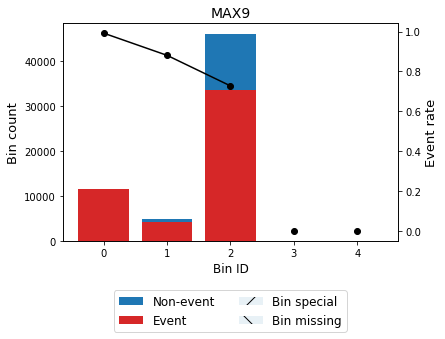

In [51]:
variable = 'MAX9'

x = train[variable].values
y = train['leaktype']

optb = OptimalBinning(name = variable, dtype = "numerical", solver = "cp", max_n_prebins = 3)
optb.fit(x, y)
    
binning_table = optb.binning_table
v1 = binning_table.build()
    
display(v1)
binning_table.plot(metric = 'event_rate')

In [52]:
x_train_transform_bins = optb.transform(train['MAX9'], metric="bins")
train['MAX9_bin'] = x_train_transform_bins

x_test_transform_bins = optb.transform(test['MAX9'], metric="bins")
test['MAX9_bin'] = x_test_transform_bins

In [53]:
from optbinning import OptimalBinning

iv_df = []

for i in categorical_list : 
    variable = i
    x = train[variable].values
    y = train['leaktype']
    
    optb = OptimalBinning(name = variable, dtype = "categorical", solver = "cp")
    optb.fit(x, y)
    
    binning_table = optb.binning_table
    v1 = binning_table.build()
    
    loop_df = pd.DataFrame({'val' : variable, 'IV' : [v1.loc['Totals', 'IV']]})
    iv_df.append(loop_df)
    
iv_df = pd.concat(iv_df).reset_index(drop = True)
iv_df.sort_values(by = ['IV'], ascending = False)

,val,IV
0,site,0.394897
3,ldate,0.051963
1,sid,0.000000
2,SiteCode,0.000000
4,lrate,0.000000


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[S-4729010101, S-4687025032, S-4380032023, S-4...",4871,0.077858,1946,2925,0.600493,0.904471,0.078934,0.009544
1,"[S-4521010100, S-4886025023, S-4784025026, S-4...",17054,0.272589,5811,11243,0.659259,0.651996,0.136728,0.016795
2,"[S-4571025029, S-2911010107, S-2711010100, S-2...",35333,0.564759,5065,30268,0.856650,-0.475748,0.110601,0.013696
3,"[S-4279025022, S-4772025022, S-4180025322, S-4...",5305,0.084795,451,4854,0.914986,-1.064102,0.068634,0.008196
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,62563,1.000000,13273,49290,0.787846,,0.394897,0.048231


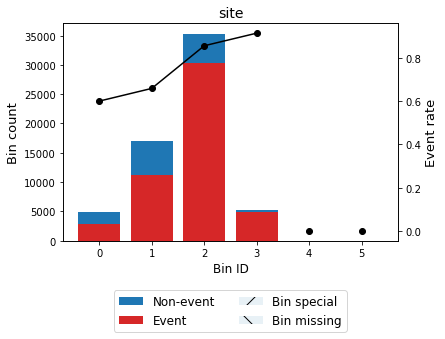

In [54]:
variable = 'site'

x = train[variable].values
y = train['leaktype']

optb = OptimalBinning(name = variable, dtype = "categorical", solver = "cp")
optb.fit(x, y)
    
binning_table = optb.binning_table
v1 = binning_table.build()
    
display(v1)
binning_table.plot(metric = 'event_rate')

In [55]:
x_train_transform_bins = optb.transform(train['site'], metric="bins")
train['site_bin'] = x_train_transform_bins

x_test_transform_bins = optb.transform(test['site'], metric="bins")
test['site_bin'] = x_test_transform_bins

- Min-Max Scaler 적용

In [56]:
# 1. dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)

In [57]:
from sklearn.preprocessing import  MinMaxScaler


numerical_list.remove('leaktype') # 이미 라벨인코딩 완료

scaler = MinMaxScaler()
train[numerical_list] = scaler.fit_transform(train[numerical_list])
test[numerical_list] = scaler.transform(test[numerical_list])

- Label Encoding

In [58]:
train.shape

(62563, 545)

In [59]:
test.shape

(15641, 545)

In [60]:
from sklearn.preprocessing import LabelEncoder

# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_list:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le
    test[col] = test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

In [61]:
train_encoded = train
test_encoded = test

In [62]:
train_encoded.shape

(62563, 545)

In [63]:
test_encoded.shape

(15641, 545)

### Modeling 준비

- 학습, 테스트 데이터셋 재정의

In [64]:
X_train_np = train_encoded.drop('leaktype', axis=1).values
y_train_np = train_encoded['leaktype'].values
X_test_np = test_encoded.drop('leaktype', axis=1).values
y_test_np = test_encoded['leaktype'].values

In [75]:
X_train = train.drop('leaktype', axis=1)
y_train = train['leaktype']
X_test = test.drop('leaktype', axis=1)
y_test = test['leaktype']

In [65]:
# X_train.info()

In [66]:
# X_test.info()

In [67]:
# 중요도를 내림차순으로 정렬하여 상위 20개 피처 출력
def plot_feature_importance(importance, names, model_type, top_n=20):
    # 중요도와 피처 이름을 데이터프레임으로 생성
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    # 중요도를 기준으로 내림차순으로 정렬
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # 상위 N개의 피처만 선택
    fi_df_top_n = fi_df.head(top_n)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    sns.barplot(x=fi_df_top_n['feature_importance'], y=fi_df_top_n['feature_names'])
    
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

### XGBoost Model

In [68]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

In [69]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# XGBoost 모델 설정
model = xgb.XGBClassifier(max_depth=8, n_estimators=100, tree_method='gpu_hist', random_state=seed)

# 모델 학습
model.fit(X_train_np, y_train_np)

# 예측
y_pred = model.predict(X_test_np)
y_pred_proba = model.predict_proba(X_test_np)

In [70]:
# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test_np, y_pred_proba, labels=[0, 1, 2, 3, 4])
print(f'Test Log Loss Score: {test_log_loss:.6f}')

Test Log Loss Score: 0.050422


In [71]:
# 정확도 평가
accuracy = accuracy_score(y_test_np, y_pred)
print(f"Accuracy: {accuracy:.6f}")

Accuracy: 0.989131


Text(0.5, 257.44, 'Predicted label')

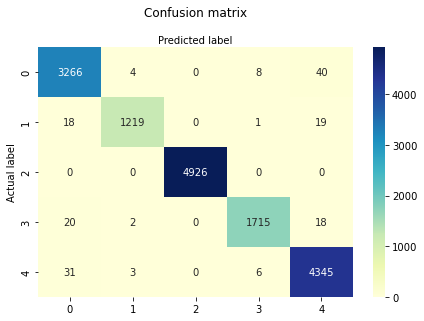

In [72]:
# confusion matric 출력
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_np, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [73]:
# 결과 리포트 출력
from sklearn.metrics import classification_report

print(classification_report(y_test_np, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3318
           1       0.99      0.97      0.98      1257
           2       1.00      1.00      1.00      4926
           3       0.99      0.98      0.98      1755
           4       0.98      0.99      0.99      4385

    accuracy                           0.99     15641
   macro avg       0.99      0.98      0.99     15641
weighted avg       0.99      0.99      0.99     15641



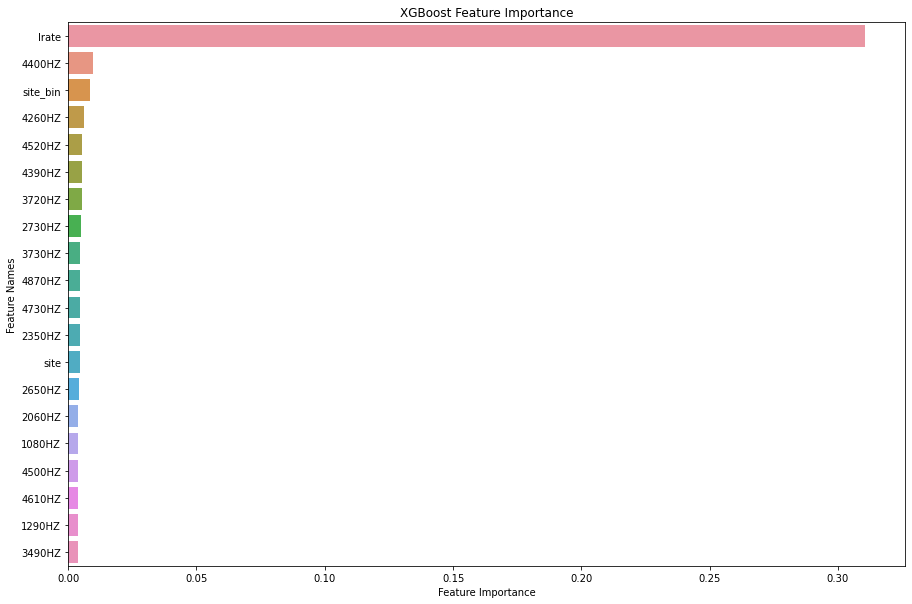

In [76]:
# feature importance 시각화
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Feature names from the training data

# 중요도를 내림차순으로 정렬하고 상위 20개 피처 시각화
plot_feature_importance(feature_importances, feature_names, "XGBoost", top_n=20)

### GridSearchCV & LGBM Classifier

In [77]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

In [127]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import numpy as np

# LGBMClassifier 모델 객체 생성
model_lgbm = LGBMClassifier(device='gpu', random_state = seed)

param_grid = {
    'max_depth': [20, 25], # 8, 10, 15, 20
    'n_estimators': [350, 400] # 100, 200, 250, 300
#     'learning_rate': [0.05, 0.1],
#     'reg_lambda': [5],
#     'min_child_samples': [20, 30],
#     'subsample': [0.5, 0.7, 1.0],
}

# GridSearchCV 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                                cv=n_fold, scoring='neg_log_loss')

# 그리드서치를 사용하여 모델 학습
grid_search_lgbm.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search_lgbm.best_params_)

Best Parameters: {'max_depth': 20, 'n_estimators': 400}


In [128]:
# 예측
y_pred_lgbm = grid_search_lgbm.predict(X_test)
y_pred_lgbm_proba = grid_search_lgbm.best_estimator_.predict_proba(X_test)

In [129]:
# 전체 데이터에 대한 Log Loss 계산
train_log_loss = log_loss(y_test, y_pred_lgbm_proba, labels=[0, 1, 2, 3, 4])
print(f'Log Loss: {train_log_loss:.6f}')

Log Loss: 0.032921


In [130]:
# 정확도 평가
accuracy = accuracy_score(y_test, y_pred_lgbm)
print(f"Accuracy: {accuracy:.6f}")

Accuracy: 0.992648


Text(0.5, 257.44, 'Predicted label')

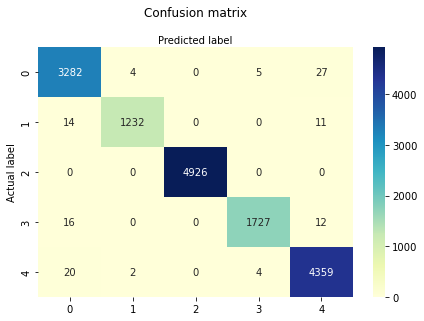

In [131]:
# confusion matric 출력
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred_lgbm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [132]:
# 결과 리포트 출력
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3318
           1       1.00      0.98      0.99      1257
           2       1.00      1.00      1.00      4926
           3       0.99      0.98      0.99      1755
           4       0.99      0.99      0.99      4385

    accuracy                           0.99     15641
   macro avg       0.99      0.99      0.99     15641
weighted avg       0.99      0.99      0.99     15641



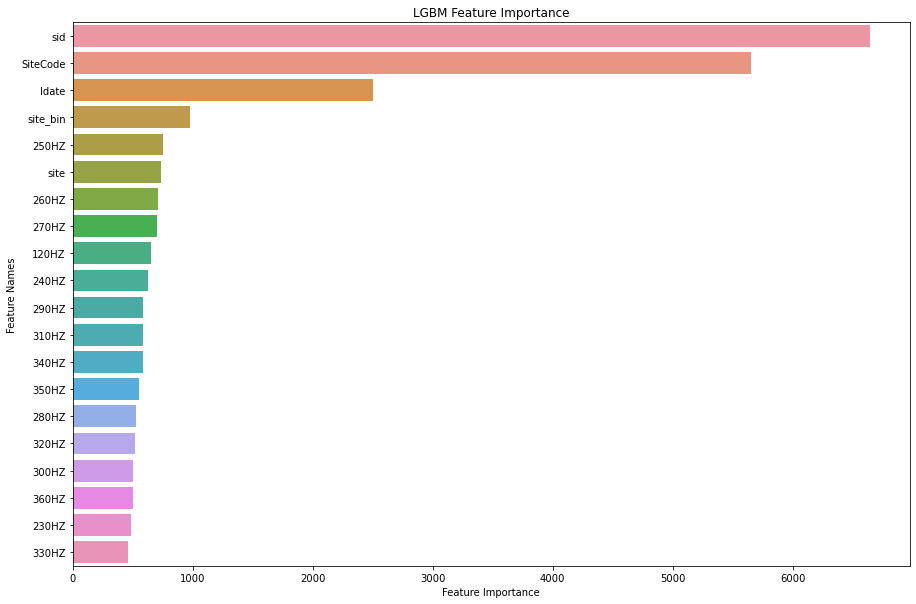

In [133]:
# feature importance 시각화
feature_importances = grid_search_lgbm.best_estimator_.feature_importances_
feature_names = X_train.columns  # Feature names from the training data

# 중요도를 내림차순으로 정렬하고 상위 20개 피처 시각화
plot_feature_importance(feature_importances, feature_names, "LGBM", top_n=20)

### GridSearch & RandomForest

In [86]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 모델 객체 생성
model_rf = RandomForestClassifier(random_state = seed)

param_grid = {
    'n_estimators': [100],
    'max_depth': [8, 10],
# #     'min_samples_split': [2, 5],
# #     'min_samples_leaf': [1, 2],
#     'max_features': ['auto', 'sqrt'],
}

# GridSearchCV 객체 생성
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=n_fold,
                              scoring='neg_log_loss')

# 그리드서치를 사용하여 모델 학습
grid_search_rf.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


In [87]:
# 결과분석
pred_y_rf_proba = grid_search_rf.predict_proba(X_test)
pred_y_rf = grid_search_rf.best_estimator_.predict(X_test)

In [88]:
# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test, pred_y_rf_proba, labels=[0, 1, 2, 3, 4])
print(f'Test Log Loss Score: {test_log_loss:.6f}')

Test Log Loss Score: 0.628607


In [89]:
# 정확도 평가
accuracy = accuracy_score(y_test, pred_y_rf)
print(f"Accuracy: {accuracy:.6f}")

Accuracy: 0.810690


Text(0.5, 257.44, 'Predicted label')

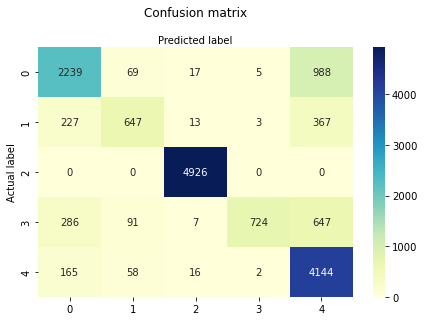

In [90]:
# confusion matric 출력
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_rf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [91]:
# 결과 리포트 출력
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_rf))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      3318
           1       0.75      0.51      0.61      1257
           2       0.99      1.00      0.99      4926
           3       0.99      0.41      0.58      1755
           4       0.67      0.95      0.79      4385

    accuracy                           0.81     15641
   macro avg       0.83      0.71      0.74     15641
weighted avg       0.83      0.81      0.80     15641



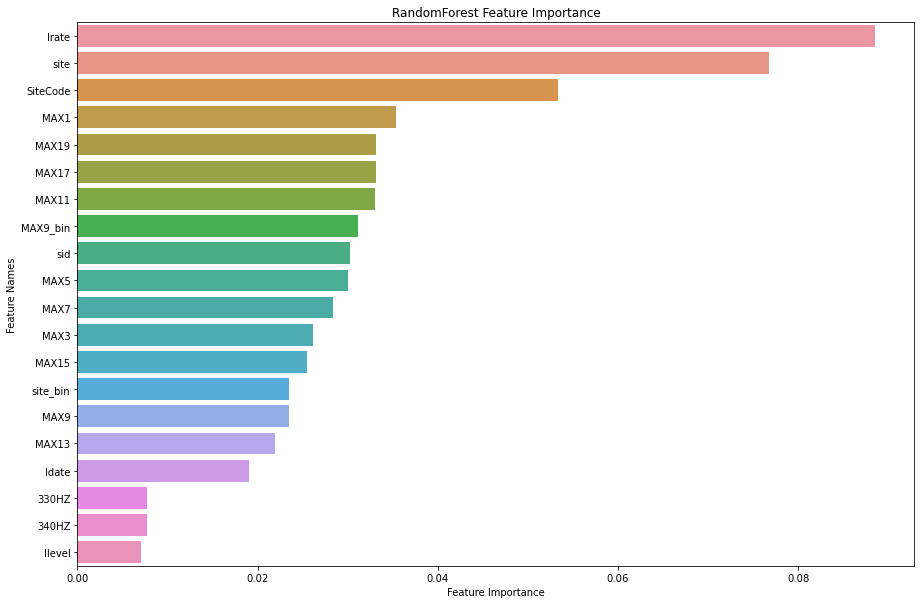

In [92]:
# feature importance 시각화
feature_importances = grid_search_rf.best_estimator_.feature_importances_
feature_names = X_train.columns  # Feature names from the training data

# 중요도를 내림차순으로 정렬하고 상위 20개 피처 시각화
plot_feature_importance(feature_importances, feature_names, "RandomForest", top_n=20)